In [1]:
%env CUDA_VISIBLE_DEVICES=

env: CUDA_VISIBLE_DEVICES=


In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from megnet.models import MEGNetModel

In [3]:
targets = ["homo", "formation_energy"]
experiments = {"clean_vac_only": r"datasets/{}_defects_vac_only.pickle.gzip",
               "clean_full": r"datasets/{}_defects.pickle.gzip"}

In [4]:
model_root = os.path.join("models", "MEGNet-defect-only")

In [5]:
save_path = os.path.join("datasets", "predicted_dichalcogenides_innopolis_202105_v2")

In [6]:
def get_prediction_column(target):
  return f"predicted_{target}"

In [7]:
columns_to_save = ["_id"] + targets + list(map(get_prediction_column, targets))

In [8]:
def process_experiment(experiment_name, data_path):
  data = {}
  for data_part in ("train", "test"):
    data[data_part] = pd.read_pickle(data_path.format(data_part))
  for target in targets:
    prediction_column = get_prediction_column(target)
    model = MEGNetModel.from_file(os.path.join(model_root, target, experiment_name))
    for this_data in data.values():
      this_data.loc[:, prediction_column] = model.predict_structures(this_data.defect_representation)
    fig, ax = plt.subplots()
    for data_name, data_part in data.items():
      ax.scatter(data_part.loc[:, target], data_part.loc[:, prediction_column],
               label=f"{data_name}, MAE="
               f"{np.mean(np.abs(data_part.loc[:, target]-data_part.loc[:, prediction_column])):.4f}",
               alpha=0.5)
    ax.set_xlabel(f"DFT {target}, eV")
    ax.set_ylabel(f"Predicted {target}, eV")
    ax.legend()

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
      ]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_title(experiment_name)
  for data_name, data_part in data.items():
    data_part.to_csv(os.path.join(save_path, f"{experiment_name}_{data_name}.csv"))

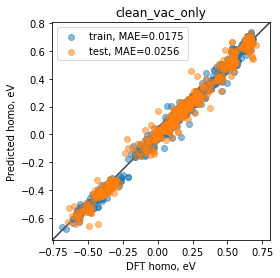

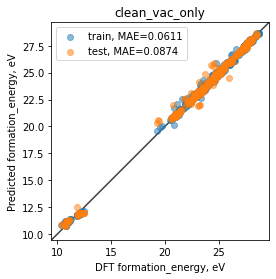

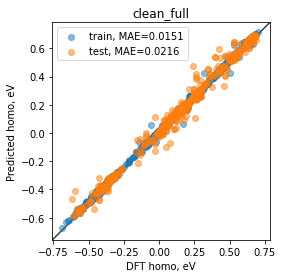

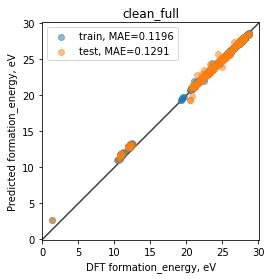

In [9]:
for name, path in experiments.items():
  process_experiment(name, path)